# Bash scripts to get the bw

In [ ]:
# samtools merge SRR2939093.sorted.bam SRR2939094.sorted.bam -o ctrl.bam
# samtools sort ctrl.bam -o ctrl.sorted.bam
# samtools index ctrl.sorted.bam

# chrs=`samtools view -H ctrl.sorted.bam | grep chr | cut -f2 | sed 's/SN://g' | grep -v chrM | grep -v Y | awk '{if(length($0)<6)print}'`
# # If paired end, use samtools view -@ $cores -b -q 30 -f 0x2 $fname.sorted.bam -o temp.bam `echo $chrs`
# samtools view -@ 16 -b -q 30 -F 260 ctrl.sorted.bam -o temp.bam `echo $chrs`
# java -jar -Djava.io.tmpdir=`pwd`/tmp /home/rzhang/software/picard.jar \
#   MarkDuplicates \
#   INPUT=temp.bam \
#   OUTPUT=ctrl.sorted.rmdup.flt.bam \
#   METRICS_FILE=ctrl.dups.log \
#   REMOVE_DUPLICATES=true \
#   VALIDATION_STRINGENCY=SILENT
# rm temp.bam
# fi

# samtools index ctrl.sorted.rmdup.flt.bam -@ 16

# macs2 callpeak --nomodel -t ctrl.sorted.rmdup.flt.bam --outdir ./peakcalling -n ctrl --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01

# bedtools slop -i ../../mm10/mm10-blacklist.v2.bed -g ../../mm10/mm10.chrom.sizes.txt -b 1057 > ./temp.bed
# bedtools intersect -v -a ./peakcalling/ctrl_peaks.narrowPeak -b ./temp.bed  > ./ctrl_no_blacklist.bed

# LC_COLLATE=C sort -k 8gr,8gr  "./ctrl_no_blacklist.bed" | awk 'BEGIN{OFS="\t"}{$4="Peak_"NR; if ($2<0) $2=0; if ($3<0) $3=0; if ($10==-1) $10=$2+int(($3-$2+1)/2.0); print $0}' > ./ctrl_peak.bed
# head -n 300000 ./ctrl_peak.bed > ./ctrl_peak2.bed

# CUDA_VISIBLE_DEVICES=1 chrombpnet prep nonpeaks \
# -g ../../mm10/mm10.fa \
# -p ./ctrl_peak2.bed \
# -c  ../../mm10/mm10.chrom.sizes.txt \
# -fl ../../mm10/folds/fold_0.json \
# -br ../../mm10/mm10-blacklist.v2.bed \
# -o ./ctrl_fold_0



# CUDA_VISIBLE_DEVICES=1 chrombpnet bias pipeline \
# -ibam ./ctrl.sorted.rmdup.flt.bam \
# -d "ATAC" \
# -g ../../mm10/mm10.fa \
# -c ../../mm10/mm10.chrom.sizes.txt \
# -p ./ctrl_peak2.bed \
# -n  ./ctrl_fold_0_negatives.bed \
# -fl ../../mm10/folds/fold_0.json \
# -o ./bias_model \
# -b 0.5 \
# -fp ctrl_fold_0

# samtools merge SRR2939095.sorted.bam SRR2939096.sorted.bam -o stim.bam
# samtools sort stim.bam -o stim.sorted.bam
# samtools index stim.sorted.bam

# chrs=`samtools view -H stim.sorted.bam | grep chr | cut -f2 | sed 's/SN://g' | grep -v chrM | grep -v Y | awk '{if(length($0)<6)print}'`
# # If paired end, use samtools view -@ $cores -b -q 30 -f 0x2 $fname.sorted.bam -o temp.bam `echo $chrs`
# samtools view -@ 16 -b -q 30 -F 260 stim.sorted.bam -o temp.bam `echo $chrs`
# java -jar -Djava.io.tmpdir=`pwd`/tmp /home/rzhang/software/picard.jar \
#   MarkDuplicates \
#   INPUT=temp.bam \
#   OUTPUT=stim.sorted.rmdup.flt.bam \
#   METRICS_FILE=stim.dups.log \
#   REMOVE_DUPLICATES=true \
#   VALIDATION_STRINGENCY=SILENT
# rm temp.bam
# fi

# samtools index stim.sorted.rmdup.flt.bam -@ 16

# Prepare sequence model

In [1]:
%load_ext autoreload
%autoreload 2
    
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import random
from tqdm.auto import *

import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

In [4]:

cleaned_peaks = scp.peak.clean_macs2('stim', '/data/rzhang/PRINT_rev/IFNStim/peakcalling',
            peak_width=128,
            blacklist_peak_width=1000,
            genome=scp.genome.mm10, filter_chr=False,
            n=999999999, fdr_threshold=0.01, use_quantile_scores=False, final_peak_width=1000
            )


Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 244777 peaks unresolved 244386 peaks selected
round: 2 21 peaks unresolved 21 peaks selected
finish clearing
finish sorting
finished summary


In [5]:
cleaned_peaks

,chrom,start,end,name,score,final_score,cell,rank
169480,chr1,3123236,3124236,stim_peak_1,3.87736,3.87736,stim,187688
227675,chr1,3132979,3133979,stim_peak_2,2.52949,2.52949,stim,238713
39258,chr1,3165090,3166090,stim_peak_3,2.52949,2.52949,stim,236157
1826,chr1,3184495,3185495,stim_peak_4,5.40122,5.40122,stim,108958
205967,chr1,3221836,3222836,stim_peak_5,4.61932,4.61932,stim,118764
...,...,...,...,...,...,...,...,...
77764,chrX,169879338,169880338,stim_peak_191819a,5.40122,5.40122,stim,101461
29188,chrX,169879733,169880733,stim_peak_191819b,5.40122,5.40122,stim,107456
109984,chrX,169880577,169881577,stim_peak_191820,11.76900,11.76900,stim,43180
155801,chrX,169881028,169882028,stim_peak_191821,6.21979,6.21979,stim,86175


In [6]:
cleaned_peaks.to_csv('/data/rzhang/PRINT_rev/IFNStim/IFNStim_cleaned_narrowPeak.bed', 
                     sep='\t', header=False, index=False)

In [7]:
from scprinter.seq.dataloader import mm10_splits
import json
for ct in ['IFNG_stim']:
    for fold in [0,1,2,3,4]:
        default_config = {
          "peaks": f"IFNStim_cleaned_narrowPeak.bed",
          "signals": f"stim_fold_0_data_unstranded.bw",
          "genome": "mm10",
          "split": mm10_splits[fold],
          "max_jitter": 128,
          "reverse_compliment": True,
          "n_filters": 1024,
          "bottleneck_factor": 1,
          "no_inception": False,
          "groups": 8,
          "n_layers": 8,
          "n_inception_layers": 8,
          "inception_layers_after": True,
          "inception_version": 2,
          "activation": "gelu",
          "batch_norm_momentum": 0.1,
          "dilation_base": 1,
          "rezero": False,
          "batch_norm": True,
          "batch_size": 64,
          "head_kernel_size": 1,
          "kernel_size": 3,
          "weight_decay": 1e-3,
          "lr": 3e-3,
          "scheduler": False,
          "savename": f"{ct}_fold{fold}",
          "amp": True,
          "ema": True,
          "notes": "v2",
          "tags": [ct, f'fold{fold}']
        }
        json.dump(default_config, open(f'./config_dir/v2/{ct}_fold{fold}.JSON', 'w'), indent=4)
        
    

In [2]:
import pandas as pd
import pyranges as pr
from pybedtools import BedTool

# Load diff ChIP data
ChIPInfo = pd.read_csv("/data/rzhang/PRINT_rev/IFNStim/Supplement_5_S2E.txt", sep="\t")

ChIPInfo['control'] = ChIPInfo['Stat2 Signal control cells']
ChIPInfo['IFN'] = ChIPInfo['Stat2 signal IFN treated cells']
ChIPInfo['FC'] = pd.to_numeric(ChIPInfo['Stat2 FoldChange'], errors='coerce').fillna(1)
# Filter based on conditions
ChIPInfo = ChIPInfo[(ChIPInfo['FC'] > 2) & (ChIPInfo['IFN'] > 3)]
ChIPInfo


,ID,chr,start,end,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),...,position,"Distance between TSS and ChIPseq summit (bp, + for summits upstream TSS, - for summits downstream TSS)",Stat2 Signal control cells,Stat2 signal IFN treated cells,Stat2 FoldChange,P.Val (t.test),Overlapping ATAC peak,control,IFN,FC
2,Stat2.peak_3,chr1,7086057,7086286,230,7086202,26,9.70869,3.92175,6.44165,...,outside,2717.0,0.84,3.36,4.00,0.1010,NaN,0.84,3.36,4.00
4,Stat2.peak_5,chr1,7397544,7398472,929,7398322,43,26.85525,7.72285,23.13663,...,outside,-309403.0,0.89,3.56,4.02,0.1620,ATAC_peak_31,0.89,3.56,4.02
6,Stat2.peak_7,chr1,9744908,9745255,348,9745085,73,29.20545,5.02344,25.45501,...,genebody,-3297.0,0.55,7.51,13.56,0.0555,NaN,0.55,7.51,13.56
7,Stat2.peak_8,chr1,9748181,9748677,497,9748503,71,54.66940,11.68293,50.67649,...,TSS,121.0,2.67,5.77,2.16,0.0201,ATAC_peak_39,2.67,5.77,2.16
9,Stat2.peak_10,chr1,9876665,9877257,593,9876962,178,208.81403,31.41796,204.31766,...,genebody,-28682.0,0.53,14.00,26.54,0.0120,ATAC_peak_51,0.53,14.00,26.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,Stat2.peak_6690,chrX,167231136,167231544,409,167231353,57,41.40761,10.18012,37.51563,...,outside,22135.0,0.41,5.76,13.98,0.0938,ATAC_peak_42349,0.41,5.76,13.98
6690,Stat2.peak_6691,chrX,167328276,167329030,755,167328724,292,402.35587,51.42717,397.56573,...,genebody,-1847.0,2.30,15.98,6.94,0.1130,ATAC_peak_42353,2.30,15.98,6.94
6691,Stat2.peak_6692,chrX,167339967,167340623,657,167340268,641,1096.12939,112.68342,1090.78796,...,outside,9697.0,8.23,35.44,4.31,0.0550,ATAC_peak_42356,8.23,35.44,4.31
6692,Stat2.peak_6693,chrX,169978882,169979430,549,169978924,28,13.42929,5.09006,10.01080,...,TSS,7.0,0.70,3.16,4.50,0.0879,ATAC_peak_42382,0.70,3.16,4.50


In [3]:
ChIPInfo = ChIPInfo.iloc[:, 1:]
ChIPInfo = scp.utils.resize_bed_df(ChIPInfo, 100)
ChIPInfo = ChIPInfo[ChIPInfo['chr'].isin(scp.genome.mm10.chrom_sizes)]
ChIPInfo

,chr,start,end,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),Related gene (overlapping or closest TSS),position,"Distance between TSS and ChIPseq summit (bp, + for summits upstream TSS, - for summits downstream TSS)",Stat2 Signal control cells,Stat2 signal IFN treated cells,Stat2 FoldChange,P.Val (t.test),Overlapping ATAC peak,control,IFN,FC
2,chr1,7086121,7086221,230,7086202,26,9.70869,3.92175,6.44165,Pcmtd1,outside,2717.0,0.84,3.36,4.00,0.1010,NaN,0.84,3.36,4.00
4,chr1,7397958,7398058,929,7398322,43,26.85525,7.72285,23.13663,Pcmtd1,outside,-309403.0,0.89,3.56,4.02,0.1620,ATAC_peak_31,0.89,3.56,4.02
6,chr1,9745031,9745131,348,9745085,73,29.20545,5.02344,25.45501,Vcpip1,genebody,-3297.0,0.55,7.51,13.56,0.0555,NaN,0.55,7.51,13.56
7,chr1,9748379,9748479,497,9748503,71,54.66940,11.68293,50.67649,Vcpip1,TSS,121.0,2.67,5.77,2.16,0.0201,ATAC_peak_39,2.67,5.77,2.16
9,chr1,9876911,9877011,593,9876962,178,208.81403,31.41796,204.31766,Sgk3,genebody,-28682.0,0.53,14.00,26.54,0.0120,ATAC_peak_51,0.53,14.00,26.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,chrX,167231290,167231390,409,167231353,57,41.40761,10.18012,37.51563,Tmsb4x,outside,22135.0,0.41,5.76,13.98,0.0938,ATAC_peak_42349,0.41,5.76,13.98
6690,chrX,167328603,167328703,755,167328724,292,402.35587,51.42717,397.56573,Tlr7,genebody,-1847.0,2.30,15.98,6.94,0.1130,ATAC_peak_42353,2.30,15.98,6.94
6691,chrX,167340245,167340345,657,167340268,641,1096.12939,112.68342,1090.78796,Tlr7,outside,9697.0,8.23,35.44,4.31,0.0550,ATAC_peak_42356,8.23,35.44,4.31
6692,chrX,169979106,169979206,549,169978924,28,13.42929,5.09006,10.01080,G530011O06Rik,TSS,7.0,0.70,3.16,4.50,0.0879,ATAC_peak_42382,0.70,3.16,4.50


In [4]:
# motif match based ov
motifs = scp.motifs.Motifs("./mouse_pfms_v4.txt",
                           scp.genome.mm10.fetch_fa(),
                           nCores=32,pvalue=5e-5,
                           mode='motifmatchr'
                          )
motifs.prep_scanner(tf_genes=None,pvalue=5e-5)
res = motifs.scan_motif(np.array(ChIPInfo), verbose=True)
res = pd.DataFrame(res)
res['chrom'] = res[0]
res['start'] = res[1] + res[7]
res['end'] = res[1] + res[8]
res['TF'] = [xx.split("_")[2] for xx in res[4]]


  0%|          | 0/6100 [00:00<?, ?it/s]

In [5]:
res = res[res['TF'] == 'Stat2']
loc = res[['chrom','start','end']]
# loc = loc.drop_duplicates(['chrom','start','end'])


In [6]:
import pyBigWig
stim = pyBigWig.open('/data/rzhang/PRINT_rev/IFNStim/stim_fold_0_data_unstranded.bw', 'r')

In [7]:
stim_insertion = []

for i,row in tqdm(loc.iterrows()):
    center = (row['start'] + row['end']) // 2
    # print (np.nansum(stim.values(row['chrom'], center-400, center+400)))
    try:
        ct = np.nansum(stim.values(row['chrom'], center-400, center+400))
    except:
        ct = 0
    stim_insertion.append(ct)
    

0it [00:00, ?it/s]

In [8]:
loc['insertion'] = stim_insertion

In [9]:
loc = loc[loc['insertion'] > 50]

In [10]:
loc

,chrom,start,end,insertion
12,chr1,7086130,7086149,51.0
106,chr1,9876916,9876935,110.0
107,chr1,9876922,9876941,109.0
108,chr1,9876987,9877006,114.0
143,chr1,10220234,10220253,89.0
...,...,...,...,...
66650,chrX,103529490,103529509,84.0
66838,chrX,164267317,164267336,55.0
66870,chrX,167175538,167175557,76.0
66890,chrX,167231342,167231361,110.0


In [126]:
loc.to_csv('/data/rzhang/PRINT_rev/IFNStim/motif_hits.bed', sep='\t', header=True, index=False)

In [39]:
loc = pd.read_csv('/data/rzhang/PRINT_rev/IFNStim/motif_hits.bed', sep='\t')

In [40]:
models= ["IFNG_stim_fold0-dulcet-plasma-541.pt", 
"IFNG_stim_fold1-smooth-dragon-539.pt", 
"IFNG_stim_fold2-kind-durian-543.pt",  
"IFNG_stim_fold3-azure-sun-540.pt", 
"IFNG_stim_fold4-kind-cosmos-542.pt"]

all = 0
for m in models:
    all += np.load(f"/data/rzhang/PRINT_rev/IFNStim/{m}_diff_results.npy")
all /= 5
all.shape

(3, 1229, 99, 800)

In [41]:
agg = all
agg = all.mean(axis=-3)

In [42]:
import pyBigWig
stim = pyBigWig.open('/data/rzhang/PRINT_rev/IFNStim/stim_fold_0_data_unstranded.bw', 'r')
ctrl = pyBigWig.open('/data/rzhang/PRINT_rev/IFNStim/ctrl_fold_0_data_unstranded.bw', 'r')
bias = pyBigWig.open('/home/rzhang/.cache/scprinter/mm10Tn5Bias.tar.gz.untar/mm10Tn5Bias.bw', 'r')

In [43]:
printer = scp.io.PyPrinter(genome=scp.genome.mm10)

Initializing GFF-db


In [44]:
printer.load_disp_model()
printer.load_bindingscore_model("TF",
                             scp.datasets.pretrained_TFBS_model)
printer.load_bindingscore_model("Nuc",
                             scp.datasets.pretrained_NucBS_model)

In [45]:
scp.sync_visualization.set_global_var(printer)

In [95]:
stim_fp = []
mask = []
for i,row in tqdm(loc.iterrows()):
    center = (row['start'] + row['end']) // 2
    # print (np.nansum(stim.values(row['chrom'], center-400, center+400)))
    try:
        ct = min(np.nansum(stim.values(row['chrom'], center-400, center+400)), np.nansum(ctrl.values(row['chrom'], center-400, center+400)))
    except:
        ct = 0
    if  ct < 100:
        mask.append(False)
        continue
    mask.append(True)
    # stim_fp.append(stim.values(row['chrom'], center-400, center+400, numpy=True)
    stim_fp.append(scp.sync_visualization._bigwig_footprint(
    stim, bias, row['chrom'], center-400, center+400, pad=100, extra=None, return_pval=True, smoothRadius=5))

0it [00:00, ?it/s]

In [96]:
ctrl_fp = []
for i,row in tqdm(loc.iterrows()):
    center = (row['start'] + row['end']) // 2
    # ctrl_fp.append(ctrl.values(row['chrom'], center-400, center+400, numpy=True))
    try:
        ct = min(np.nansum(stim.values(row['chrom'], center-400, center+400)), np.nansum(ctrl.values(row['chrom'], center-400, center+400)))
    except:
        ct = 0
    if  ct < 100:
        # ctrl_fp.append(np.zeros((99, 800)))
        continue
    ctrl_fp.append(scp.sync_visualization._bigwig_footprint(
    ctrl, bias, row['chrom'], center-400, center+400, pad=100, extra=None, return_pval=True, smoothRadius=5))

0it [00:00, ?it/s]

In [97]:
pred_delta_per_site = all[2]

In [98]:
pred_delta_per_site = pred_delta_per_site[np.array(mask)]

In [99]:
gt_delta_per_site = -np.array(stim_fp) + np.array(ctrl_fp)
gt_delta_per_site.shape 

(490, 99, 800)

In [100]:
pred_delta_per_site.shape

(490, 99, 800)

In [101]:
gt_delta_per_site.shape

(490, 99, 800)

In [107]:
corrs = []
from scipy.stats import *
for x,y in zip(pred_delta_per_site, gt_delta_per_site):
    # print( np.mean(np.abs(y)))
    corrs.append(pearsonr(x[10:50, 200:-200].reshape((-1)), -1 * y[10:50, 200:-200].reshape((-1)))[0])

-0.012597810256213779


/tmp/ipykernel_428145/1502535818.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(corrs)


<Axes: ylabel='Density'>

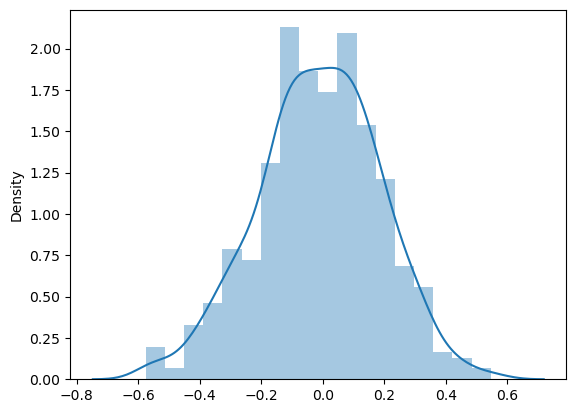

In [108]:
print (np.mean(corrs))
sns.distplot(corrs)

In [19]:
gt_delta = np.array(stim_fp).mean(axis=0) - np.array(ctrl_fp).mean(axis=0)
print (gt_delta.shape)

(99, 800)


In [109]:
agg[2].shape

(99, 800)

In [123]:
from scipy.stats import *
pearsonr(agg[2][:, 200:-200].reshape((-1)), -gt_delta[:, 200:-200].reshape((-1)))

PearsonRResult(statistic=0.22757583718629215, pvalue=0.0)

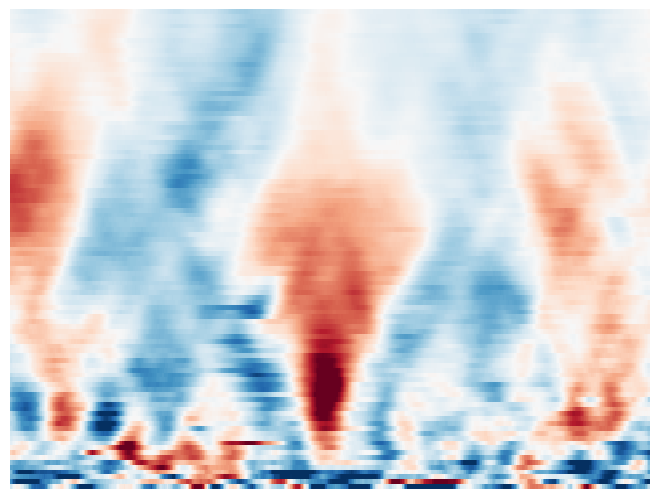

In [119]:
ax = sns.heatmap(-gt_delta[::-1][:, 200:-200], cmap='RdBu', vmin=-0.07, vmax=0.07, cbar=False)
ax.axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

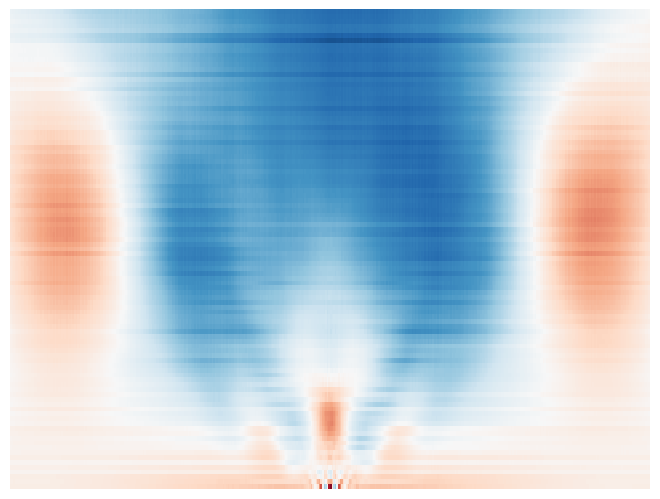

In [120]:
ax = sns.heatmap(agg[2][::-1][:, 200:-200], cmap='RdBu', vmin=-0.07, vmax=0.07, cbar=False)
ax.axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
# ax.set_title('GR')
# plt.savefig('/data/rzhang/PRINT_rev/IFNStim/model_delta_vmax_0.07_400bp.png')
# plt.savefig('/data/rzhang/PRINT_rev/paakinaho_dexamethasone_atac/IMR90_model_delta_vmax_0.05_800bp.png')

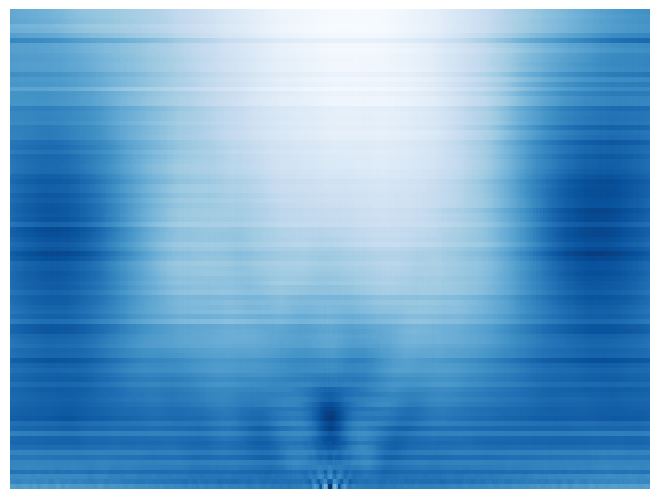

In [201]:
ax = sns.heatmap(agg[0][::-1][:, 200:-200], cmap='Blues', cbar=False)
ax.axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
# ax.set_title('GR')
# plt.savefig('/data/rzhang/PRINT_rev/paakinaho_dexamethasone_atac/IMR90_model_delta_vmax_0.05_800bp.png')

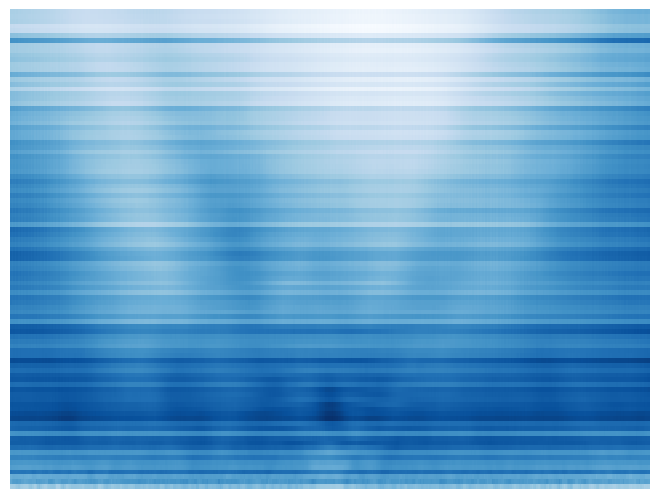

In [202]:
ax = sns.heatmap(agg[1][::-1][:, 200:-200], cmap='Blues', cbar=False)
ax.axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
# ax.set_title('GR')
# plt.savefig('/data/rzhang/PRINT_rev/paakinaho_dexamethasone_atac/IMR90_model_delta_vmax_0.05_800bp.png')

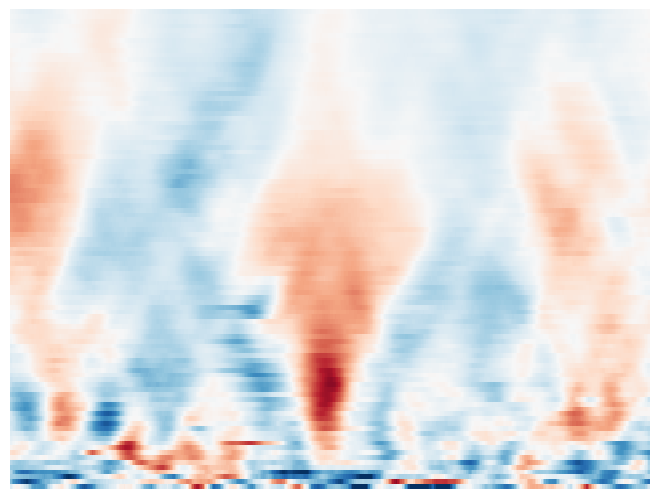

In [207]:
ax = sns.heatmap(gt_delta[::-1][:, 200:-200], cmap='RdBu_r', vmin=-0.1, vmax=0.1, cbar=False)
ax.axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
# ax.set_title('GR')
plt.savefig('/data/rzhang/PRINT_rev/IFNStim/observed_delta_vmax_0.1_400bp.png')

In [112]:
print()